In [36]:
import pandas as pd
import quandl
import datetime
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [37]:
# Load the Excel file
excel_file_path = '/Users/kevinwang/Desktop/stocks/Apple Inc.(AAPL)..xlsx'
apple_data = pd.read_excel(excel_file_path)
apple_data = apple_data.loc[::-1]

apple_data.head()

,Date,Last Price,Volume,SMAVG (15)
3789,2009-01-30,3.219,651821568,NaN
3788,2009-02-02,3.268,558413440,NaN
3787,2009-02-03,3.321,599443264,NaN
3786,2009-02-04,3.341,808413056,NaN
3785,2009-02-05,3.445,749400128,NaN


In [38]:
# Set the date as the index of the dataframe
apple_data.set_index('Date', inplace=True)

# Parameters for the moving averages
short_lookback_period = 40  # days
long_lookback_period = 100  # days

# Calculate the moving averages
apple_data['short_mavg'] = apple_data['Last Price'].rolling(window=short_lookback_period, min_periods=1, center=False).mean()
apple_data['long_mavg'] = apple_data['Last Price'].rolling(window=long_lookback_period, min_periods=1, center=False).mean()

# Initialize the signal column
apple_data['signal'] = 0.0

# Generate signals
apple_data['signal'][short_lookback_period:] = np.where(apple_data['short_mavg'][short_lookback_period:] > apple_data['long_mavg'][short_lookback_period:], 1.0, 0.0)

# Calculate the position (the difference of signals to identify crossovers)
apple_data['position'] = apple_data['signal'].diff()

# Preview the dataset with new columns
apple_data[['Last Price', 'short_mavg', 'long_mavg', 'signal', 'position']].head()


<ipython-input-38-d3a5b739f5ff>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_data['signal'][short_lookback_period:] = np.where(apple_data['short_mavg'][short_lookback_period:] > apple_data['long_mavg'][short_lookback_period:], 1.0, 0.0)


,Last Price,short_mavg,long_mavg,signal,position
Date,,,,,
2009-01-30,3.219,3.219000,3.219000,0.0,NaN
2009-02-02,3.268,3.243500,3.243500,0.0,0.0
2009-02-03,3.321,3.269333,3.269333,0.0,0.0
2009-02-04,3.341,3.287250,3.287250,0.0,0.0
2009-02-05,3.445,3.318800,3.318800,0.0,0.0


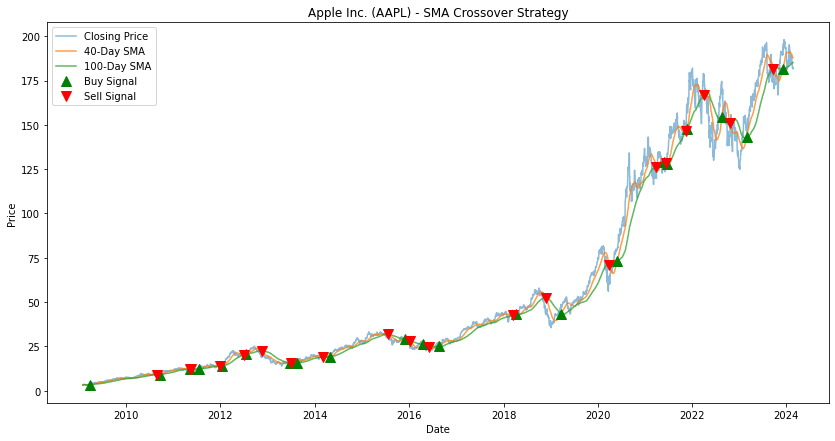

In [48]:
import matplotlib.pyplot as plt

# Plotting the closing prices, short-term and long-term moving averages
plt.figure(figsize=(14, 7))
plt.plot(apple_data['Last Price'], label='Closing Price', alpha=0.5)
plt.plot(apple_data['short_mavg'], label='40-Day SMA', alpha=0.75)
plt.plot(apple_data['long_mavg'], label='100-Day SMA', alpha=0.75)

# Highlighting the buy signals
plt.plot(apple_data[apple_data['position'] == 1].index, 
         apple_data['short_mavg'][apple_data['position'] == 1], 
         '^', markersize=10, color='g', lw=0, label='Buy Signal')

# Highlighting the sell signals
plt.plot(apple_data[apple_data['position'] == -1].index, 
         apple_data['short_mavg'][apple_data['position'] == -1], 
         'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title('Apple Inc. (AAPL) - SMA Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
save_path = '/Users/kevinwang/Desktop/output graph/apple_SMA.png'
plt.savefig(save_path)


plt.show()


In [47]:
# Calculate daily returns
apple_data['daily_return'] = apple_data['Last Price'].pct_change()

# Strategy returns: Multiplying daily returns by the position (1 for holding, 0 for not)
apple_data['strategy_return'] = apple_data['daily_return'] * apple_data['signal'].shift()

# Cumulative returns
apple_data['cumulative_strategy_return'] = (1 + apple_data['strategy_return']).cumprod()
apple_data['cumulative_market_return'] = (1 + apple_data['daily_return']).cumprod()

# Sharpe Ratio (annualized)
risk_free_rate = 0.0
days_in_year = 252
sharpe_ratio = (apple_data['strategy_return'].mean() / apple_data['strategy_return'].std()) * np.sqrt(days_in_year)

# Max Drawdown
rolling_max = apple_data['cumulative_strategy_return'].cummax()
daily_drawdown = apple_data['cumulative_strategy_return']/rolling_max - 1.0
max_drawdown = daily_drawdown.min()

# Average Win and Loss
average_win = apple_data[apple_data['strategy_return'] > 0]['strategy_return'].mean()
average_loss = apple_data[apple_data['strategy_return'] < 0]['strategy_return'].mean()

# Buy and Hold Return
buy_and_hold_return = (apple_data['Last Price'].iloc[-1] - apple_data['Last Price'].iloc[0])/apple_data['Last Price'].iloc[0]
# Strategy Return
strategy_return = apple_data['cumulative_strategy_return'].iloc[-1] - 1

{
    "sharpe_ratio": round(sharpe_ratio, 2),
    "cumulative_strategy_return": round(strategy_return,2),
    "max_drawdown": round(max_drawdown,2),
    "average_win": round(average_win,2),
    "average_loss": round(average_loss,2),
    "buy_and_hold": round(buy_and_hold_return,2)
}


{'sharpe_ratio': 0.89,
 'cumulative_strategy_return': 14.03,
 'max_drawdown': -0.36,
 'average_win': 0.01,
 'average_loss': -0.01,
 'buy_and_hold': 55.64}